**Install Packages**

In [11]:
!pip install uv
!uv pip install kaggle --system
!uv pip install umap-learn --system

Using Python 3.10.12 environment at /usr
Audited 1 package in 142ms
Using Python 3.10.12 environment at /usr
Audited 1 package in 62ms


**Import Libraries**

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

In [13]:
from sklearn.decomposition import FactorAnalysis, IncrementalPCA, KernelPCA, PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS, TSNE
from umap import UMAP

In [14]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()
standard_scaler = StandardScaler()

In [15]:
import ipywidgets as widgets

from google.colab import output
output.enable_custom_widget_manager()

**Download Datasets**

In [16]:
# Mount Google drive and copy kaggle.json to local disk

from google.colab import drive
drive.mount('mount')

!cp mount/MyDrive/kaggle.json .

Drive already mounted at mount; to attempt to forcibly remount, call drive.mount("mount", force_remount=True).


In [17]:
!KAGGLE_CONFIG_DIR=$(pwd) kaggle datasets download kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)


In [25]:
!unzip -o skin-cancer-mnist-ham10000.zip -d /content/skin-cancer-mnist-ham10000

Streaming output truncated to the last 5000 lines.
  inflating: /content/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/skin-cancer-mnist

In [26]:
!ls /content/skin-cancer-mnist-ham10000/

ham10000_images_part_1	HAM10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_1	HAM10000_metadata.csv	hmnist_8_8_L.csv
ham10000_images_part_2	hmnist_28_28_L.csv	hmnist_8_8_RGB.csv


**Load and Prepare Datasets**

In [27]:
HAM10000_metadata = pd.read_csv('/content/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
HAM10000_metadata.head(5)

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [28]:
HAM10000_metadata['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [29]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_type_to_df = {}
for lesion_type in lesion_type_dict.keys():
  lesion_type_to_df[lesion_type] = HAM10000_metadata[HAM10000_metadata['dx'] == lesion_type]

lesion_type_to_df

{'nv':         lesion_id      image_id  dx    dx_type   age     sex     localization
 64    HAM_0001751  ISIC_0024698  nv  consensus  70.0    male             face
 1210  HAM_0000559  ISIC_0024693  nv  follow_up  45.0  female  upper extremity
 2976  HAM_0004932  ISIC_0032212  nv  follow_up  45.0  female             foot
 2977  HAM_0004516  ISIC_0025775  nv  follow_up  45.0  female             neck
 2978  HAM_0006510  ISIC_0029828  nv  follow_up  55.0  female  lower extremity
 ...           ...           ...  ..        ...   ...     ...              ...
 9682  HAM_0006283  ISIC_0027924  nv  consensus  20.0    male            chest
 9683  HAM_0000102  ISIC_0031547  nv  consensus  20.0    male             back
 9684  HAM_0000102  ISIC_0032221  nv  consensus  20.0    male             back
 9685  HAM_0005314  ISIC_0030693  nv  consensus  40.0    male             neck
 9686  HAM_0003322  ISIC_0031649  nv  consensus  50.0  female             face
 
 [6705 rows x 7 columns],
 'mel':          l

In [30]:
import cv2

image = cv2.imread('/content/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029382.jpg')

grayscaled_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

resized_grayscaled_image = cv2.resize(grayscaled_image, (128, 128))

resized_grayscaled_image.shape

(128, 128)

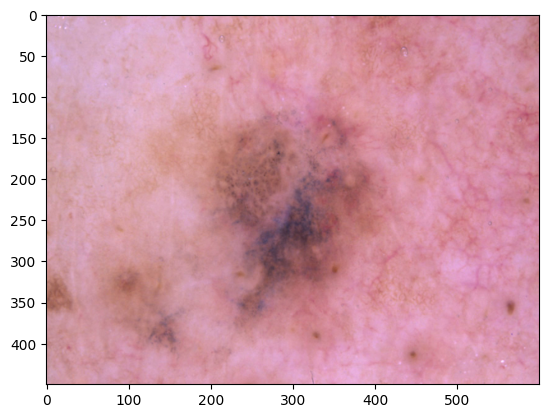

In [32]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

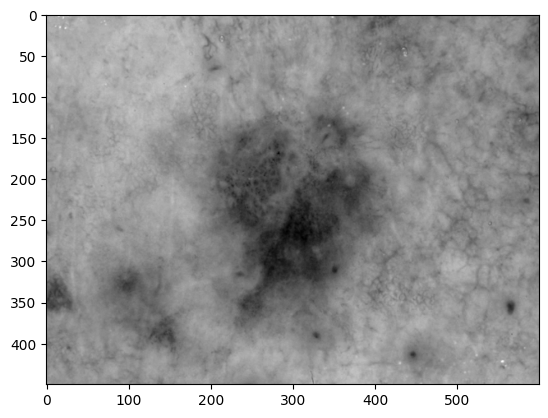

In [33]:
plt.imshow(grayscaled_image, cmap='gray')

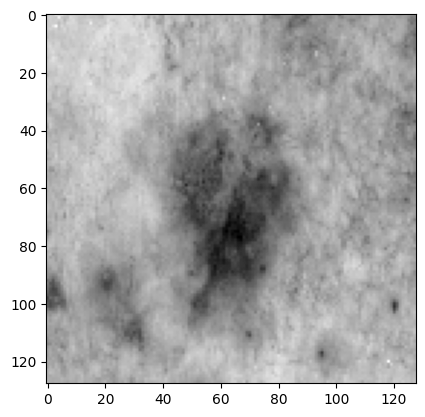

In [34]:
plt.imshow(resized_grayscaled_image, cmap='gray')

In [35]:
image_dirnames = [
    'ham10000_images_part_1',
    'HAM10000_images_part_1',
    'ham10000_images_part_2',
    'HAM10000_images_part_2',
]
image_dirs = ['/content/skin-cancer-mnist-ham10000/' + dir for dir in image_dirnames]
image_dirs

['/content/skin-cancer-mnist-ham10000/ham10000_images_part_1',
 '/content/skin-cancer-mnist-ham10000/HAM10000_images_part_1',
 '/content/skin-cancer-mnist-ham10000/ham10000_images_part_2',
 '/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2']

In [36]:
import os

all_image_paths = []
lesion_type_to_images_df = {}

def get_image_path(image_name):
  for image_dir in image_dirs:
    image_path = os.path.join(image_dir, image_name) + ".jpg"
    if os.path.exists(image_path):
      return image_path
  return None

import cv2

def convert_image_to_grayscale(image_path):
  image = cv2.imread(image_path)
  if image is None:
    return None

  grayscaled_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  resized_grayscaled_image = cv2.resize(grayscaled_image, (128, 128))
  scaled_and_resized_grayscaled_image = resized_grayscaled_image / 255.0
  return scaled_and_resized_grayscaled_image

for lesion_type, lesion_type_df in lesion_type_to_df.items():
  lesion_type_to_images_df[lesion_type] = []
  for index, row in lesion_type_df.iterrows():
    image_path = get_image_path(row['image_id'])
    if not image_path:
      continue

    image = convert_image_to_grayscale(image_path)
    if image is None:
      continue

    lesion_type_to_images_df[lesion_type].append(image)
    all_image_paths.append(image_path)

  lesion_type_to_images_df[lesion_type] = np.array(lesion_type_to_images_df[lesion_type])
  print(lesion_type_to_images_df[lesion_type].shape)

(6705, 128, 128)
(1113, 128, 128)
(1099, 128, 128)
(514, 128, 128)
(327, 128, 128)
(142, 128, 128)
(115, 128, 128)


<h1>Dimensionality Reduction: Randomized PCA, Kernel PCA, Incremental PCA</h1>

In [127]:
lesion_type = "bkl"

lesion_type_df = lesion_type_to_images_df[lesion_type]
lesion_type_df.shape

(1099, 128, 128)

In [157]:
lesion_images_reshaped = lesion_type_df.reshape(lesion_type_df.shape[0], lesion_type_df.shape[1] * lesion_type_df.shape[2])
lesion_images_reshaped.shape

(1099, 16384)

In [193]:
randomized_pca = PCA(svd_solver='randomized', n_components=350)
lesion_images_randomized_pca = randomized_pca.fit_transform(lesion_images_reshaped)

kernel_pca = KernelPCA(n_components=350, fit_inverse_transform=True)
lesion_images_kernel_pca = kernel_pca.fit_transform(lesion_images_reshaped)

incremental_pca = IncrementalPCA(n_components=350)
lesion_images_incremental_pca = incremental_pca.fit_transform(lesion_images_reshaped)

In [174]:
randomized_pca.explained_variance_ratio_[:10]

array([0.35886008, 0.18222629, 0.05567909, 0.04387552, 0.03088362,
       0.02561759, 0.02337271, 0.01896986, 0.01696179, 0.0121652 ])

In [175]:
print(lesion_images_randomized_pca.shape)
print(lesion_images_kernel_pca.shape)
print(lesion_images_incremental_pca.shape)

(1099, 350)
(1099, 350)
(1099, 350)


In [177]:
lesion_images_randomized_pca_inverse = randomized_pca.inverse_transform(lesion_images_randomized_pca)
lesion_images_kernel_pca_inverse = kernel_pca.inverse_transform(lesion_images_kernel_pca)
lesion_images_incremental_pca_inverse = incremental_pca.inverse_transform(lesion_images_incremental_pca)

print(lesion_images_randomized_pca_inverse.shape)
print(lesion_images_kernel_pca_inverse.shape)
print(lesion_images_incremental_pca_inverse.shape)

(1099, 16384)
(1099, 16384)
(1099, 16384)


In [181]:
lesion_images_randomized_pca_inverse_reshaped = lesion_images_randomized_pca_inverse.reshape(lesion_type_df.shape[0], lesion_type_df.shape[1], lesion_type_df.shape[2])
lesion_images_kernel_pca_inverse_reshaped = lesion_images_kernel_pca_inverse.reshape(lesion_type_df.shape[0], lesion_type_df.shape[1], lesion_type_df.shape[2])
lesion_images_incremental_pca_inverse_reshaped = lesion_images_incremental_pca_inverse.reshape(lesion_type_df.shape[0], lesion_type_df.shape[1], lesion_type_df.shape[2])

print(lesion_images_randomized_pca_inverse_reshaped.shape)
print(lesion_images_kernel_pca_inverse_reshaped.shape)
print(lesion_images_incremental_pca_inverse_reshaped.shape)

(1099, 128, 128)
(1099, 128, 128)
(1099, 128, 128)


<h1>Visualizations: Randomized PCA, Kernel PCA, Incremental PCA</h1>

**Original Image**

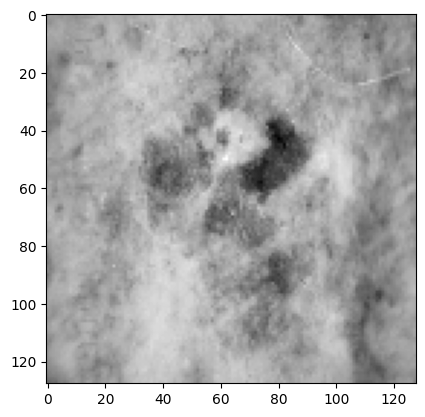

In [153]:
plt.imshow(lesion_type_df[0], cmap='gray')

**Randomized PCA**

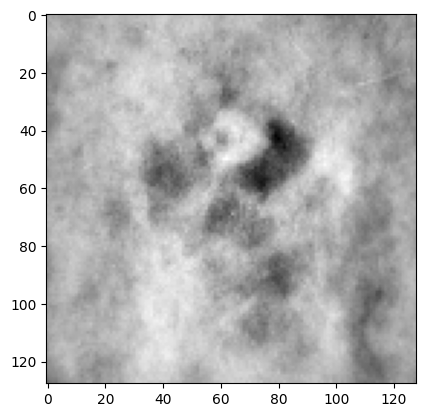

In [182]:
plt.imshow(lesion_images_randomized_pca_inverse_reshaped[0], cmap='gray')

**Kernel PCA**

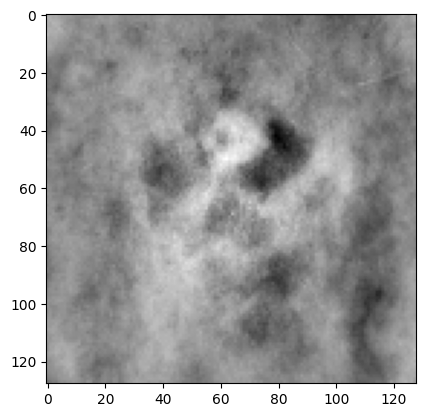

In [183]:
plt.imshow(lesion_images_kernel_pca_inverse_reshaped[0], cmap='gray')

**Incremental PCA**

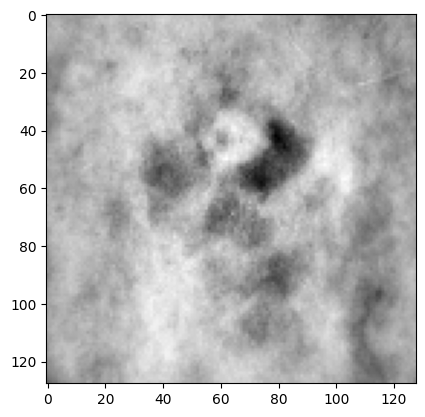

In [184]:
plt.imshow(lesion_images_incremental_pca_inverse_reshaped[0], cmap='gray')

<h1>Dimensionality Reduction: Factor Analysis, LLE, Isomap, and MDS</h1>

In [197]:
all_lesion_images = []

for lesion_type, lesion_images_df in lesion_type_to_images_df.items():
    all_lesion_images.extend(lesion_images_df)

all_lesion_images = np.array(all_lesion_images)
all_lesion_images.shape

(10015, 128, 128)

In [216]:
all_lesion_images_reshaped = all_lesion_images.reshape(all_lesion_images.shape[0], all_lesion_images.shape[1] * all_lesion_images.shape[2])
all_lesion_images_reshaped.shape

(10015, 16384)

In [200]:
factor_analysis = FactorAnalysis(n_components=3, max_iter=4000)
lesion_images_factor_analysis = factor_analysis.fit_transform(all_lesion_images_reshaped)

lle = LocallyLinearEmbedding(n_components=3, eigen_solver='dense')
lesion_images_lle = lle.fit_transform(all_lesion_images_reshaped)

isomap = Isomap(n_components=3)
lesion_images_isomap = isomap.fit_transform(all_lesion_images_reshaped)

mds = MDS(n_components=3)
lesion_images_mds = mds.fit_transform(all_lesion_images_reshaped)

<h1>Visualizations: Factor Analysis, LLE, IsoMap, and MDS</h1>

In [217]:
colors = np.array(["blue", "red", "green", "purple", "orange", "yello", "black"])

In [219]:
lesion_point_z = []

count = 0
for lesion_type, lesion_df in lesion_type_to_df.items():
  lesion_point_z.extend([count] * len(lesion_df))
  count += 1

lesion_point_colors = colors[lesion_point_z]
print("Lesion Point Colors: " + str(pd.Series(lesion_point_colors).unique()))

Lesion Point Colors: ['blue' 'red' 'green' 'purple' 'orange' 'yello' 'black']


**Factor Analysis**

In [207]:
px.scatter_3d(lesion_images_factor_analysis, x=0, y=1, z=2, color=lesion_point_colors)

In [208]:
px.scatter_3d(lesion_images_lle, x=0, y=1, z=2, color=lesion_point_colors)

In [209]:
px.scatter_3d(lesion_images_isomap, x=0, y=1, z=2, color=lesion_point_colors)

In [220]:
px.scatter_3d(lesion_images_mds, x=0, y=1, z=2, color=lesion_point_colors)

<h1>Dimensionality Reduction: tSNE and UMAP</h1>

In [211]:
def update_plot(df, n_components, dimensionality_reduction_method, color, **hyperparameters):
    reducer = dimensionality_reduction_method(n_components=n_components, **hyperparameters)
    df_reduced = reducer.fit_transform(df)

    if n_components == 2:
      plotter_method = px.scatter
      components = {"x": 0, "y": 1}
    elif n_components == 3:
      plotter_method = px.scatter_3d
      components = {"x": 0, "y": 1, "z": 2}
    else:
      raise Exception("Only 2 or 3 n_components supported")

    # Create an interactive scatter plot
    fig = plotter_method(df_reduced, color=color, **components,
                    #  labels={'x': 'Component 1', 'y': 'Component 2', 'z': 'Component 3'},
                     title=f'{dimensionality_reduction_method.__name__} - {str(hyperparameters)}')
    fig.show()

In [212]:
from functools import partial

def make_partial_function(*args):
  partial_function = partial(update_plot, *args)
  partial_function.__name__ = update_plot.__name__
  return partial_function

In [213]:
# Create sliders for interactive control of hyperparameters
perplexity_slider = widgets.IntSlider(value=30, min=5, max=50, step=1, description='perplexity')
learning_rate_slider = widgets.IntSlider(value=200, min=10, max=500, step=10, description='learning_rate')

# Link sliders to the update function
widgets.interactive(make_partial_function(all_lesion_images_reshaped, 3, TSNE, lesion_point_colors), perplexity=perplexity_slider, learning_rate=learning_rate_slider)

interactive(children=(IntSlider(value=30, description='perplexity', max=50, min=5), IntSlider(value=200, descr…

In [214]:
# Create sliders for interactive control of hyperparameters
n_neighbors_slider = widgets.IntSlider(value=15, min=5, max=50, step=1, description='n_neighbors')
min_dist_slider = widgets.FloatSlider(value=0.1, min=0.0, max=0.9, step=0.05, description='min_dist')

# Link sliders to the update function
widgets.interactive(make_partial_function(all_lesion_images_reshaped, 3, UMAP, lesion_point_colors), n_neighbors=n_neighbors_slider, min_dist=min_dist_slider)

interactive(children=(IntSlider(value=15, description='n_neighbors', max=50, min=5), FloatSlider(value=0.1, de…

<h1>Dimensionality Reduction: AutoEncoders</h1>

In [2]:
!git clone https://github.com/facebookresearch/ImageBind.git
!pip install git+https://github.com/facebookresearch/pytorchvideo.git@eb04d1b21e08cfd0713164c0907aeb4c98fd83af timm==0.6.7 ftfy regex einops fvcore decord==0.6.0

fatal: destination path 'ImageBind' already exists and is not an empty directory.
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision eb04d1b21e08cfd0713164c0907aeb4c98fd83af) to /tmp/pip-req-build-3yl_vpqi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-req-build-3yl_vpqi
  Running command git rev-parse -q --verify 'sha^eb04d1b21e08cfd0713164c0907aeb4c98fd83af'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git eb04d1b21e08cfd0713164c0907aeb4c98fd83af
  Running command git checkout -q eb04d1b21e08cfd0713164c0907aeb4c98fd83af
  Resolved https://github.com/facebookresearch/pytorchvideo.git to commit eb04d1b21e08cfd0713164c0907aeb4c98fd83af
  Preparing metadata (setup.py) ... done


In [6]:
%cd /content/ImageBind

/content/ImageBind


In [9]:
import imagebind.data
import torch
import os
from functools import reduce
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [37]:
inputs = {
    ModalityType.VISION: imagebind.data.load_and_transform_vision_data(all_image_paths[:1000], device),
}

In [38]:
with torch.no_grad():
    embeddings = model(inputs)

In [48]:
embeddings['vision']

tensor([[ 2.7480e-02,  4.0654e-04, -1.2445e-03,  ...,  6.8549e-03,
          2.7530e-02,  1.8148e-02],
        [ 1.7778e-02, -1.3467e-02, -1.3426e-02,  ..., -1.5954e-03,
          2.0414e-02, -5.3698e-03],
        [-1.1130e-02, -2.6251e-03, -8.6274e-03,  ...,  1.4154e-02,
          2.5709e-02, -1.8121e-03],
        ...,
        [ 1.9439e-02, -3.8020e-03, -1.9296e-02,  ...,  2.5536e-02,
          7.9457e-03, -9.8372e-04],
        [ 9.2419e-03,  1.7165e-05,  9.6934e-04,  ...,  1.9937e-02,
          3.2590e-02,  1.4391e-02],
        [ 8.7770e-03, -6.5782e-03, -1.7944e-02,  ..., -2.0188e-02,
          2.8389e-02,  1.3524e-02]])

In [50]:
len(embeddings['vision'])

1000

In [49]:
embeddings['vision'][0]

tensor([ 0.0275,  0.0004, -0.0012,  ...,  0.0069,  0.0275,  0.0181])

In [47]:
len(embeddings['vision'][0])

1024